## Deep Learning Model Uncertainty

This notebook introduces uncertainty into the neural network by fitting multiple neural networks and predicting the target variable mutliple times. It then makes use of the boostrap resampling method in order to calculate a confidence interval of the non-normally distributed data.

Note: the experiments are performed on the test set only.

In [2]:
#importing necessary packages
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Input
import pandas as pd
import numpy as np
import random
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from keras.backend import clear_session
from keras.layers import Dense, Activation
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.backend import clear_session
from keras.layers import Dense, Activation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#removing the seed for the cross validation and tensorflow so that each trained neural network produces slightly different results
cross_validation = KFold(n_splits = 3, shuffle = True)#, random_state = 10)

#seed = 14
#tf.random.set_seed(14)

In [4]:
#checking if GPU is being used 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8059903605795045235
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15457484800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7128830100459144183
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:02:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [5]:
#read dataframe from the Data Preparation Notebook 
df_complete3 = pd.read_pickle('df_complete3_v3.pickle')

In [6]:
#change types of the whole dataframe so that we do not run out of memory during the training process 
df_complete3 = df_complete3.astype(np.uint8)

In [7]:
#split off target column
target_column = df_complete3['number of conflicts']
df_complete3.drop(columns = ['number of conflicts'], inplace = True)

In [8]:
#perform train-test-split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_complete3, target_column, test_size = 0.08, random_state = 0)


In [9]:
#normalize the data with a StandardScaler - performance regarding simple model is better, so we continue with the Standard Scaler!
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Shadow\anaconda3\envs\tf-keras-gpu-2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [27]:
#defining the best model
def wider_larger_model(dropout_rate, weight_constraint):
    clear_session()
    model = Sequential()
    del model
    model = Sequential()
    
    model.add(Dense(40, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(60, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(50, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(30, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(20, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(10, kernel_initializer='normal', activation='relu', kernel_constraint = MaxNorm(2)))
    model.add(Dropout(0.05))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error')
    return model

In [28]:
#train the model, epochs is reduced to 50 in order to speed up the training process
model = KerasRegressor(model=wider_larger_model, verbose=2, epochs = 50, batch_size = 2000, optimizer = "Adam",
                      loss = 'mean_squared_error', optimizer__learning_rate = 0.1) 
#seed = 14
#tf.random.set_seed(14)
# define the grid search parameters
weight_constraint = [4]
dropout_rate = [0.0]
# Make a dictionary of the grid search parameters
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint = weight_constraint )


grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=1, cv= cross_validation, scoring = "neg_mean_squared_error")
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
31/31 - 2s - loss: 372.6836 - 2s/epoch - 73ms/step
Epoch 2/50
31/31 - 0s - loss: 324.3102 - 397ms/epoch - 13ms/step
Epoch 3/50
31/31 - 0s - loss: 312.7819 - 481ms/epoch - 16ms/step
Epoch 4/50
31/31 - 0s - loss: 307.0690 - 413ms/epoch - 13ms/step
Epoch 5/50
31/31 - 0s - loss: 301.9804 - 449ms/epoch - 14ms/step
Epoch 6/50
31/31 - 0s - loss: 295.5125 - 426ms/epoch - 14ms/step
Epoch 7/50
31/31 - 0s - loss: 289.4407 - 460ms/epoch - 15ms/step
Epoch 8/50
31/31 - 0s - loss: 282.6102 - 466ms/epoch - 15ms/step
Epoch 9/50
31/31 - 1s - loss: 275.2035 - 517ms/epoch - 17ms/step
Epoch 10/50
31/31 - 1s - loss: 270.0999 - 500ms/epoch - 16ms/step
Epoch 11/50
31/31 - 0s - loss: 263.5545 - 495ms/epoch - 16ms/step
Epoch 12/50
31/31 - 0s - loss: 257.2988 - 468ms/epoch - 15ms/step
Epoch 13/50
31/31 - 0s - loss: 251.5548 - 465ms/epoch - 15ms/step
Epoch 14/50
31/31 - 0s - loss: 246.9151 - 498ms/epoch - 16ms/step
Epoch 15/50
31/31 - 0s - loss: 239.1118 - 456ms/epoch - 15ms/step
Epoch 16/50
31/31 - 0s

Epoch 25/50
31/31 - 1s - loss: 207.2810 - 519ms/epoch - 17ms/step
Epoch 26/50
31/31 - 1s - loss: 207.1432 - 530ms/epoch - 17ms/step
Epoch 27/50
31/31 - 0s - loss: 206.5284 - 485ms/epoch - 16ms/step
Epoch 28/50
31/31 - 0s - loss: 201.4693 - 496ms/epoch - 16ms/step
Epoch 29/50
31/31 - 0s - loss: 204.3696 - 491ms/epoch - 16ms/step
Epoch 30/50
31/31 - 0s - loss: 200.6376 - 487ms/epoch - 16ms/step
Epoch 31/50
31/31 - 0s - loss: 198.7814 - 488ms/epoch - 16ms/step
Epoch 32/50
31/31 - 0s - loss: 197.4022 - 488ms/epoch - 16ms/step
Epoch 33/50
31/31 - 1s - loss: 199.1936 - 515ms/epoch - 17ms/step
Epoch 34/50
31/31 - 0s - loss: 195.6756 - 479ms/epoch - 15ms/step
Epoch 35/50
31/31 - 0s - loss: 195.4274 - 494ms/epoch - 16ms/step
Epoch 36/50
31/31 - 1s - loss: 190.9255 - 501ms/epoch - 16ms/step
Epoch 37/50
31/31 - 0s - loss: 193.5900 - 478ms/epoch - 15ms/step
Epoch 38/50
31/31 - 0s - loss: 191.1633 - 499ms/epoch - 16ms/step
Epoch 39/50
31/31 - 1s - loss: 188.8714 - 504ms/epoch - 16ms/step
Epoch 40/5

In [29]:
#predictions are created for both the train and the test set
y_pred_train1 = grid.predict(X_train)
y_pred_test1 = grid.predict(X_test)

47/47 - 0s - 231ms/epoch - 5ms/step
5/5 - 0s - 31ms/epoch - 6ms/step


In [13]:
#create rounding functions
import math
def round_over_3(numb):
    decimal_first = numb - int(numb)
    decimal_first = int(decimal_first * 10) 
    if decimal_first < 3:
        return math.floor(numb)
    return math.ceil(numb)

def round_over_9(numb):
    decimal_first = numb - int(numb)
    decimal_first = int(decimal_first * 10) 
    if decimal_first < 9:
        return math.floor(numb)
    return math.ceil(numb)

In [13]:
#predicting the values mutliple times for resampling -this was done twice and the values have been saved 
#to csv files which are imported in the following
predictions_train = pd.DataFrame()
predictions_test = pd.DataFrame()

for i in range(0,100):
    model_name = "model" + str(i)
    print(model_name)
    model = KerasRegressor(model=wider_larger_model, verbose=0, epochs = 50, batch_size = 2000, optimizer = "Adam",
                      optimizer__learning_rate = 0.1, loss = 'mean_squared_error')

    # define the grid search parameters
    weight_constraint = [4]
    
    dropout_rate = [0.0]
    # Make a dictionary of the grid search parameters
    param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint = weight_constraint )

    grid = GridSearchCV(estimator=model, param_grid = param_grid, n_jobs=1, cv= cross_validation, scoring = "neg_mean_squared_error")
    grid_result = grid.fit(X_train, y_train)
    
    y_pred_train = grid.predict(X_train)
    y_pred_test = grid.predict(X_test)

    predictions_train[model_name] = y_pred_train
    predictions_test[model_name] = y_pred_test

model0
model1
model2
model3
model4
model5


KeyboardInterrupt: 

In [ ]:
predictions_train.to_csv("predictions_train3.csv")
predictions_test.to_csv("predictions_test3.csv")

In [14]:
#read the predictions files which have multiple predictions from different DL models 
predictions_train = pd.read_csv("predictions_train3.csv", index_col = 0)
predictions_test = pd.read_csv("predictions_test3.csv", index_col = 0)

In [15]:
#calculate the mean per row 
y_pred_test_mean = predictions_test.apply(lambda x: x.mean(), axis = 1)
y_pred_train_mean = predictions_train.apply(lambda x: x.mean(), axis = 1)

In [16]:
#calculate error measures with the mean of the 100 predictions
MSE = mean_squared_error(y_test , y_pred_test_mean)
MAE = mean_absolute_error(y_test, y_pred_test_mean)
print('Average test MAE = ', MAE)
print('Average test MSE = ', MSE)

MSE = mean_squared_error(y_train , y_pred_train_mean)
MAE = mean_absolute_error(y_train, y_pred_train_mean)
print('Average train MAE = ', MAE)
print('Average train MSE = ', MSE)

Average test MAE =  3.425623415139874
Average test MSE =  124.09108632106108
Average train MAE =  3.4894954841565013
Average train MSE =  137.18950978178245


Average test MAE =  3.425623415139874
Average test MSE =  124.09108632106108
Average train MAE =  3.4894954841565013
Average train MSE =  137.18950978178245

In [17]:
#compare error mean error measure to the one from the one trained neural network
MSE = mean_squared_error(y_test , y_pred_test1)
MAE = mean_absolute_error(y_test, y_pred_test1)
print('Single Model test MAE = ', MAE)
print('Single Model test MSE = ', MSE)

MSE = mean_squared_error(y_train , y_pred_train1)
MAE = mean_absolute_error(y_train, y_pred_train1)
print('Single Model train MAE = ', MAE)
print('Single Model train MSE = ', MSE)

Single Model test MAE =  3.8956172
Single Model test MSE =  160.8108
Single Model train MAE =  3.978242
Single Model train MSE =  178.38228


Single Model test MAE =  3.52456
Single Model test MSE =  140.92168
Single Model train MAE =  3.5643253
Single Model train MSE =  151.70477

The average error measures of the many models always outperform the error measures of the predictions resulting from one neural network. 

#### Creating Confidence Intervals

The confidence interval for the predictions is calculated by making use of the resampling bootstrap method. In specific, the data is resampled 100 times with 100 observations per resample. The mean of each resample is then calculated and used to construct a confidence interval.

In [23]:
resample_mean_mean = [] #mean of the resample
lower_ci = [] #lower confidence interval of resampled mean
upper_ci =  [] #upper confidence interval of resampled mean
alpha = 0.95 #confidence level
df = pd.DataFrame(columns = range(1, 200) )

for index, row in predictions_test.iterrows():
    resample_mean = []
    
    for i in range(1, 200):
        row_temp = predictions_test.loc[index, :].values.tolist()
        y = random.choices(row_temp, k = 100)
        avg = np.mean(y)
        resample_mean.append(avg)
    
    #calculate the confidence interval for ther resampled means 
    resample_mean.sort()
    df.loc[len(df)] = resample_mean
    lower = np.percentile(resample_mean, 1)
    upper = np.percentile(resample_mean,99)
    
  #  x = np.percentile(resample_mean, [1, 50, 97.5])
    lower_ci.append(lower)
    upper_ci.append(upper)
    
    #calculate the mean of the resampled means
    resample_mean_mean.append(np.mean(resample_mean))

In [24]:
#all the different calculated measures are written into a new dataframe
new_df = pd.DataFrame()

new_df["lower_ci"] = lower_ci
new_df["upper_ci"] = upper_ci
new_df["resample_mean"] = resample_mean_mean
new_df["original_mean"] = predictions_test.apply(lambda x: x.mean(), axis = 1)
#new_df["difference"] = new_df["upper_ci"] - new_df["lower_ci"] 
new_df["original_pred"] = y_pred_test1
new_df["actual_value"] = y_test.to_numpy()
new_df

,lower_ci,upper_ci,resample_mean,original_mean,original_pred,actual_value
0,0.544610,0.669257,0.612732,0.615182,0.491900,0
1,0.666900,0.809293,0.733965,0.731816,0.566721,0
2,0.603244,0.746687,0.670402,0.669120,0.700632,0
3,0.590529,0.713028,0.651849,0.647724,0.778255,0
4,53.405667,61.876157,57.815335,57.721309,103.667969,50
...,...,...,...,...,...,...
7999,0.639898,0.813848,0.727467,0.724869,0.536934,0
8000,0.641280,0.797576,0.710796,0.707389,0.584453,4
8001,1.137394,1.794948,1.401095,1.416263,0.675895,0
8002,0.533847,0.653332,0.594448,0.590827,0.502971,0


In [30]:
#visualize the different values for one specific prediciton
preds = df[26:27].to_numpy()
preds = preds[0]
preds_lower_ci = new_df.iloc[26]['lower_ci']
preds_upper_ci = new_df.iloc[26]['upper_ci']
preds_resample_mean = new_df.iloc[26]['resample_mean']
preds_original = new_df.iloc[26]['original_pred']
preds_actual = new_df.iloc[26]['actual_value']

C:\Users\Shadow\AppData\Local\Temp\ipykernel_11568\1866305771.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(preds, shade=True, color = "lightgreen", label = "resampled means")


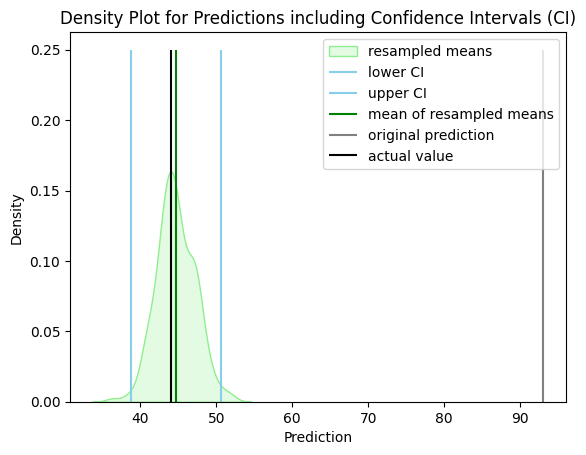

In [32]:
sns.kdeplot(preds, shade=True, color = "lightgreen", label = "resampled means")
plt.vlines(preds_lower_ci, 0, 0.25, color='skyblue', label = "lower CI")
plt.vlines(preds_upper_ci, 0, 0.25, color = 'skyblue', label = "upper CI")
plt.vlines(preds_resample_mean, 0, 0.25, color = 'green', label = "mean of resampled means")
plt.vlines(preds_original,0, 0.25, color = 'grey', label = "original prediction")
plt.vlines(preds_actual,0, 0.25, color = 'black', label = "actual value")

plt.legend(loc = "upper right")
plt.title("Density Plot for Predictions including Confidence Intervals (CI)")
plt.xlabel("Prediction")
plt.show()

#### Calculate some more metrics with rounding

In [23]:
#original metrics from one neural network rounded
y_pred_test1_rounded_floor = new_df["original_pred"].apply(np.floor)
y_pred_test1_rounded_ceiling = new_df["original_pred"].apply(np.ceil)

In [24]:
#metrics with floor 
MSE_test = mean_squared_error(y_test, y_pred_test1_rounded_floor)
MAE_test = mean_absolute_error(y_test , y_pred_test1_rounded_floor)
print('Original Prediction floor rounding MAE = ', MAE_test)
print('Original Prediction floor rounding MSE = ', MSE_test)

# metrics with ceiling 
MSE_test = mean_squared_error(y_test, y_pred_test1_rounded_ceiling)
MAE_test = mean_absolute_error(y_test , y_pred_test1_rounded_ceiling)
print('Original Prediction ceiling rounding MAE = ', MAE_test)
print('Original Prediction ceiling rounding MSE = ', MSE_test)

Original Prediction floor rounding MAE =  3.0769615
Original Prediction floor rounding MSE =  142.03398
Original Prediction ceiling rounding MAE =  3.7873564
Original Prediction ceiling rounding MSE =  140.4083


Original Prediction floor rounding MAE =  3.0769615
Original Prediction floor rounding MSE =  142.03398
Original Prediction ceiling rounding MAE =  3.7873564
Original Prediction ceiling rounding MSE =  140.4083

In [25]:
#metrics on the rouded after 0.3 data
y_pred_mean_rounded3 = [round_over_3(i) for i in y_pred_test1]

MSE_test = mean_squared_error(y_test, y_pred_mean_rounded3)
MAE_test = mean_absolute_error(y_test , y_pred_mean_rounded3)
print('Original Prediction 0.3 rounding MAE = ', MAE_test)
print('Original Prediction 0.3 rounding MSE = ', MSE_test)

#metrics on the rouded after 0.9 data
y_pred_mean_rounded9 = [round_over_9(i) for i in y_pred_test1]

MSE_test = mean_squared_error(y_test, y_pred_mean_rounded9)
MAE_test = mean_absolute_error(y_test , y_pred_mean_rounded9)
print('Original Prediction 0.9 rounding MAE = ', MAE_test)
print('Original Prediction 0.9 rounding MSE = ', MSE_test)

Original Prediction 0.3 rounding MAE =  3.671789105447276
Original Prediction 0.3 rounding MSE =  140.76299350324837
Original Prediction 0.9 rounding MAE =  3.143303348325837
Original Prediction 0.9 rounding MSE =  141.74550224887557


Original Prediction 0.3 rounding MAE =  3.671789105447276
Original Prediction 0.3 rounding MSE =  140.76299350324837
Original Prediction 0.9 rounding MAE =  3.143303348325837
Original Prediction 0.9 rounding MSE =  141.74550224887557


rounded_floor performs best in comparison to all rounding methods!

In [26]:
#metrics on resampled mean - performs better than any of the above
y_pred_resampled_mean = new_df[["resample_mean"]].to_numpy() 
MSE_test = mean_squared_error(y_test, y_pred_resampled_mean)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean)
print('Resampled Mean test MAE = ', MAE_test)
print('Resampled Mean test MSE = ', MSE_test)

Resampled Mean test MAE =  3.426208761544967
Resampled Mean test MSE =  124.1974301505221


Resampled Mean test MAE =  3.426208761544967
Resampled Mean test MSE =  124.1974301505221

In [27]:
#metrics on the resampled mean rounded down
new_df["rounded_down"] = new_df["resample_mean"].apply(np.floor)
y_pred_resampled_floor = new_df[["rounded_down"]].to_numpy() 

#metrics on floor
MSE_test = mean_squared_error(y_test, y_pred_resampled_floor)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_floor)
print('Resampled Mean floor_rounding test MAE = ', MAE_test)
print('Resampled Mean floor_rounding test MSE = ', MSE_test)

Resampled Mean floor_rounding test MAE =  2.973513243378311
Resampled Mean floor_rounding test MSE =  124.77561219390304


Resampled Mean floor_rounding test MAE =  2.973513243378311
Resampled Mean floor_rounding test MSE =  124.77561219390304

Resampled mean rounded down performs best!

In [28]:
#metrics on the rounded up data
new_df["rounded_up"] = new_df["resample_mean"].apply(np.ceil)
y_pred_resampled_ceil = new_df[["rounded_up"]].to_numpy() 
                      
#metrics on ceiling
MSE_test = mean_squared_error(y_test, y_pred_resampled_ceil)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_ceil)
print('Resampled Mean ceiling_rounding test MAE = ', MAE_test)
print('Resampled Mean ceiling_rounding test MSE = ', MSE_test)

Resampled Mean ceiling_rounding test MAE =  3.714142928535732
Resampled Mean ceiling_rounding test MSE =  124.22688655672164


Resampled Mean ceiling_rounding test MAE =  3.714142928535732
Resampled Mean ceiling_rounding test MSE =  124.22688655672164

In [29]:
#metrics on the rounded down data 0.9
y_pred_resampled = new_df[["resample_mean"]].to_numpy() 
y_pred_resampled_mean_rounded9 = [round_over_9(i) for i in y_pred_resampled]

MSE_test = mean_squared_error(y_test, y_pred_resampled_mean_rounded9)
MAE_test = mean_absolute_error(y_test , y_pred_resampled_mean_rounded9)
print('Resampled Mean 0.9_rounding test MAE = ', MAE_test)
print('Resampled Mean 0.9_rounding test MSE = ', MSE_test)

Resampled Mean 0.9_rounding test MAE =  3.0219890054972516
Resampled Mean 0.9_rounding test MSE =  124.65992003998001


Resampled Mean 0.9_rounding test MAE =  3.0219890054972516
Resampled Mean 0.9_rounding test MSE =  124.65992003998001

Rounding all entries down produces the best predictions!

Resampling the data and calculating the mean of the resamples produces the most accurate results. In addition, this methods has the advantage of providing confidence intervals which is good for interpretation purposes and allocation of resources regarding conflict predictions. 